In [1]:
import cv2
import numpy as np
import skimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Introduction code

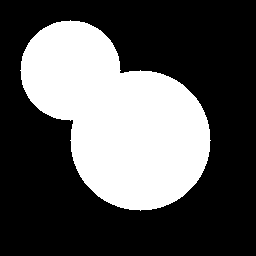

In [2]:
img = np.zeros((256, 256),dtype="uint8")
cv2.circle(img, (70,70), 50, (255,255,255), (-1))
cv2.circle(img, (140,140), 70, (255,255,255), (-1))
cv2_imshow(img)

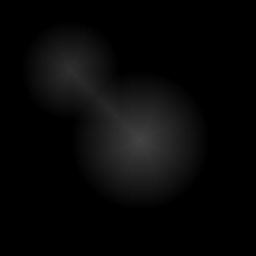

In [3]:
dist_transform = cv2.distanceTransform(img, cv2.DIST_L2,3)
cv2_imshow(dist_transform)

In [4]:
local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)
local_max_boolean = peak_local_max(dist_transform, min_distance=1, indices=False)

print(local_max_boolean)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Peak Local Max

In [5]:
img1 = np.zeros((7, 7))
img1[2, 2] = 4
img1[2, 4] = 7
print(img1)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 4. 0. 7. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [6]:
peak_local_max(img1, min_distance=1)

array([[2, 4],
       [2, 2]])

In [7]:
peak_local_max(img1, min_distance=2)

array([[2, 4]])

In [10]:
markers, _ = ndi.label(local_max_boolean)
segmented = skimage.segmentation.watershed(255-dist_transform, markers, mask=img)

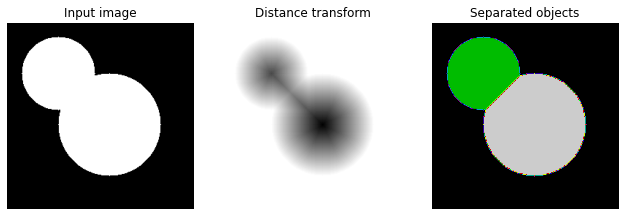

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[1].imshow(-dist_transform, cmap=plt.cm.gray)
ax[1].set_title('Distance transform')
ax[2].imshow(segmented, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

# Applying watershed

In [12]:
!wget https://pbs.twimg.com/media/EYINRgoXgAAfxwx.jpg -O "Oranges.jpg"

--2020-12-02 08:39:06--  https://pbs.twimg.com/media/EYINRgoXgAAfxwx.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 93.184.220.70, 2606:2800:134:1a0d:1429:742:782:b6
Connecting to pbs.twimg.com (pbs.twimg.com)|93.184.220.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125613 (123K) [image/jpeg]
Saving to: ‘Oranges.jpg’

Oranges.jpg         100%[===================>] 122.67K  --.-KB/s    in 0.01s   

2020-12-02 08:39:06 (12.1 MB/s) - ‘Oranges.jpg’ saved [125613/125613]



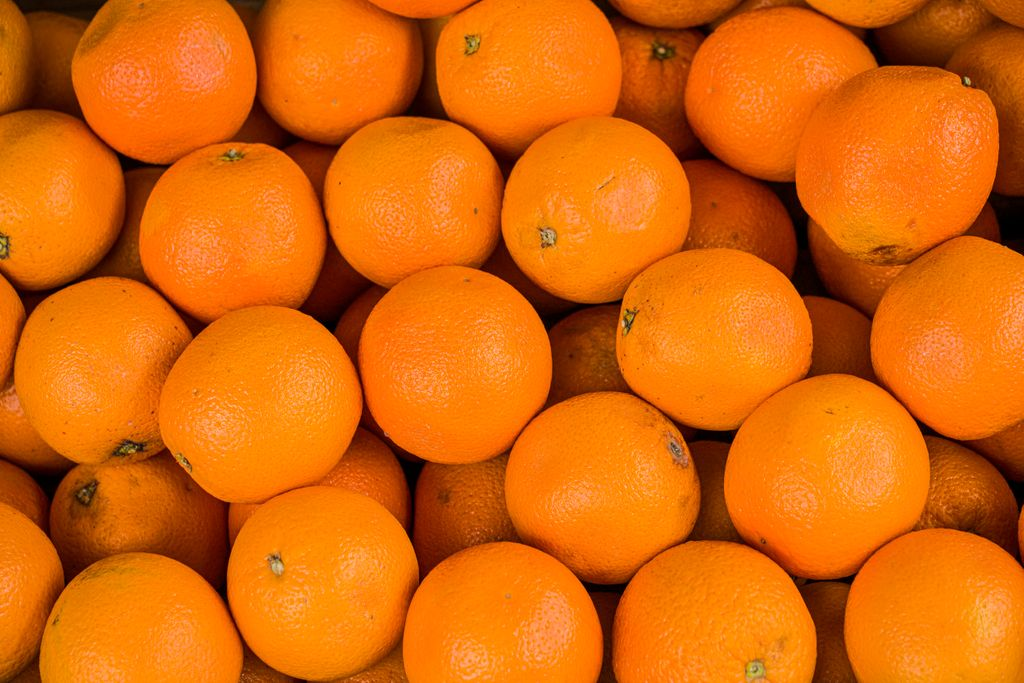

In [13]:
img = cv2.imread('Oranges.jpg')
cv2_imshow(img)

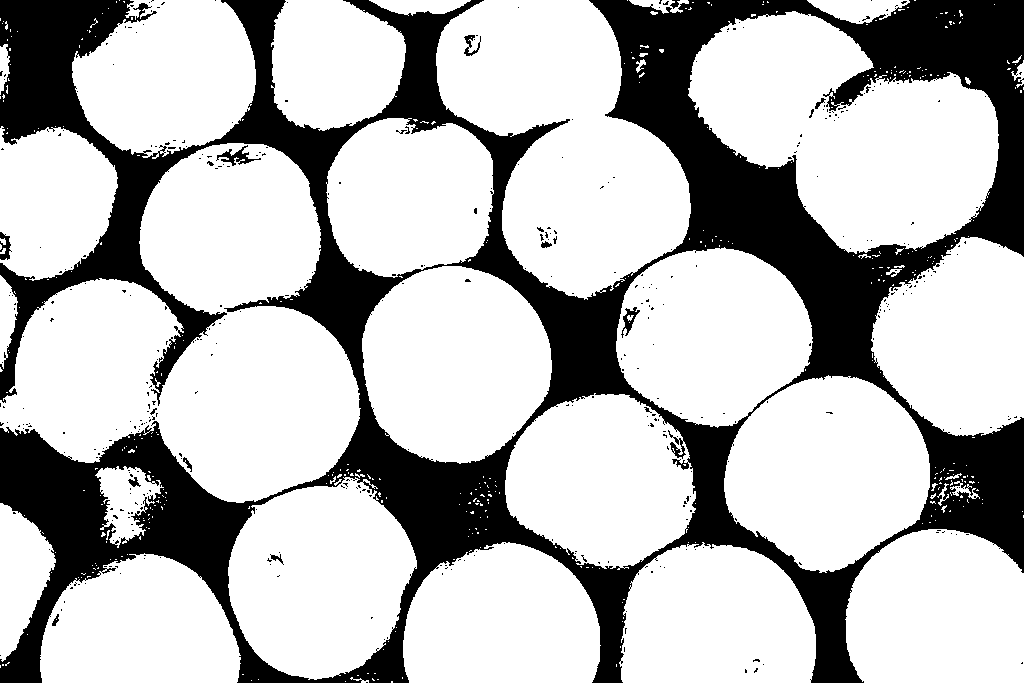

In [14]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
cv2_imshow(thresh)

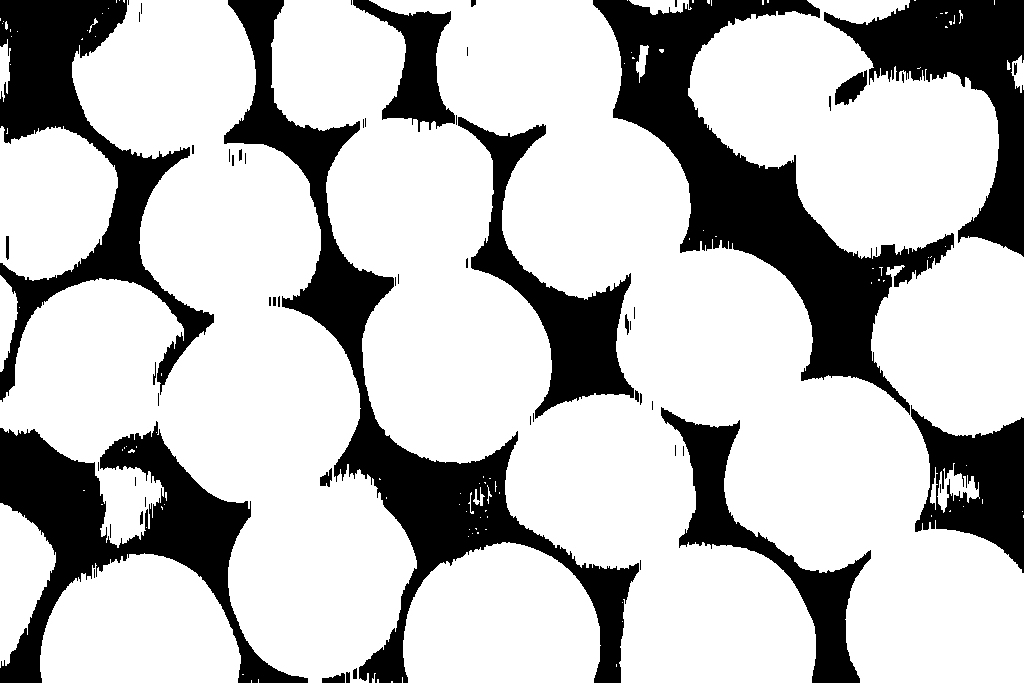

In [17]:
# Noise removal
kernel = np.ones((3),np.uint8)
closing_img = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel, iterations = 4)

cv2_imshow(closing_img)

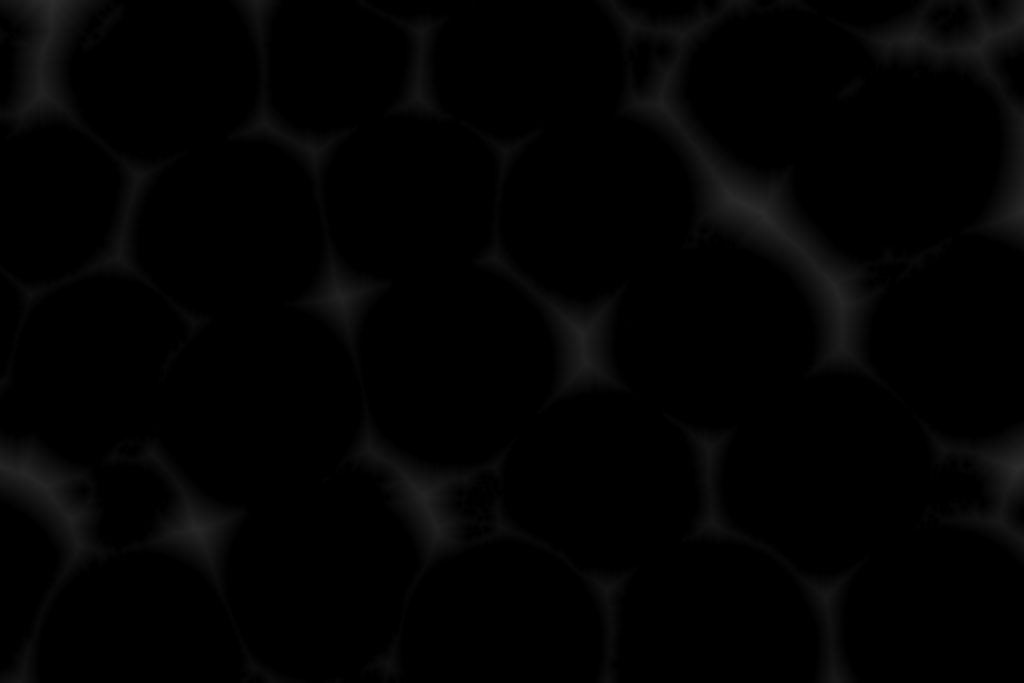

In [18]:
dist_transform = cv2.distanceTransform(255 - closing_img, cv2.DIST_L2, 3)
cv2_imshow(dist_transform)

In [19]:
index_local_max = local_max_location != 0

In [20]:
local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30)
kmeans.fit(local_max_location)
local_max_location = kmeans.cluster_centers_.copy()

In [22]:
#Kmeans is returning a float data type. but we need to convert it to an int. 
local_max_location = local_max_location.astype(int)

In [23]:
local_max_location.shape
dist_transform_copy = dist_transform.copy()
for i in range(local_max_location.shape[0]):
  cv2.circle( dist_transform_copy, (local_max_location[i][1],local_max_location[i][0]  ), 5, 255 )

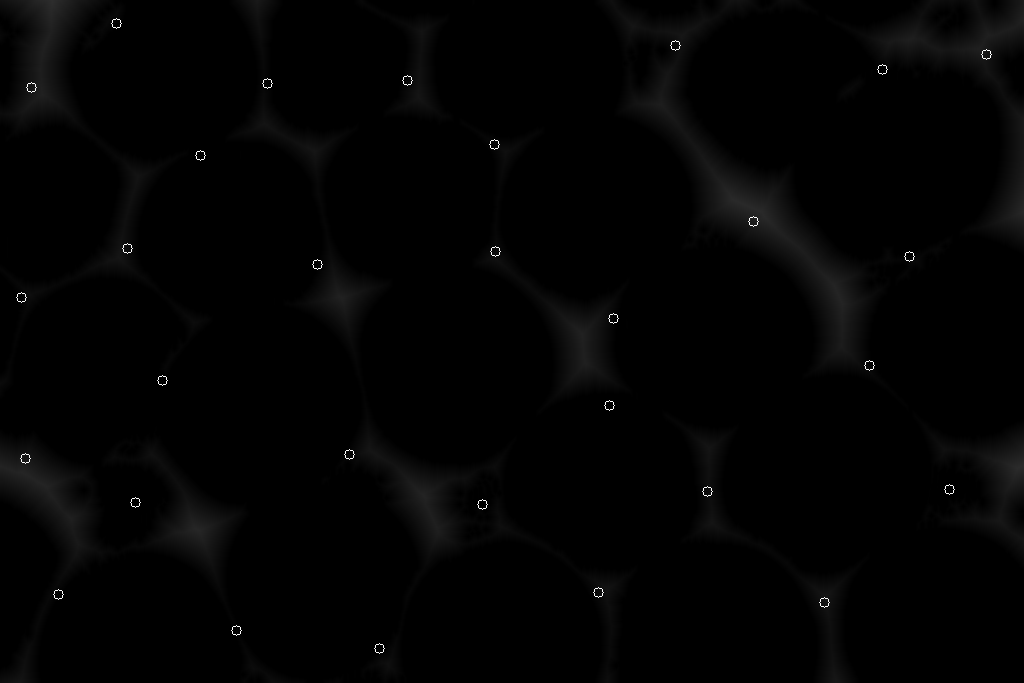

In [24]:
cv2_imshow(dist_transform_copy)

In [25]:
markers = np.zeros_like(dist_transform)
labels = np.arange(kmeans.n_clusters)
markers[local_max_location[:,0],local_max_location[:,1]   ] = labels + 1

In [26]:
markers = markers.astype(int) 

In [27]:
markers_copy = markers.copy()
index_non_zero_markers = np.argwhere(markers != 0)

In [28]:
markers_copy = markers_copy.astype(np.uint8)

In [29]:
index_non_zero_markers
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(index_non_zero_markers.shape[0]):
  string_text = str(markers[index_non_zero_markers[i][0] ,index_non_zero_markers[i][1]    ])
  cv2.putText( markers_copy, string_text, (index_non_zero_markers[i][1], index_non_zero_markers[i][0]), font, 1, 255)

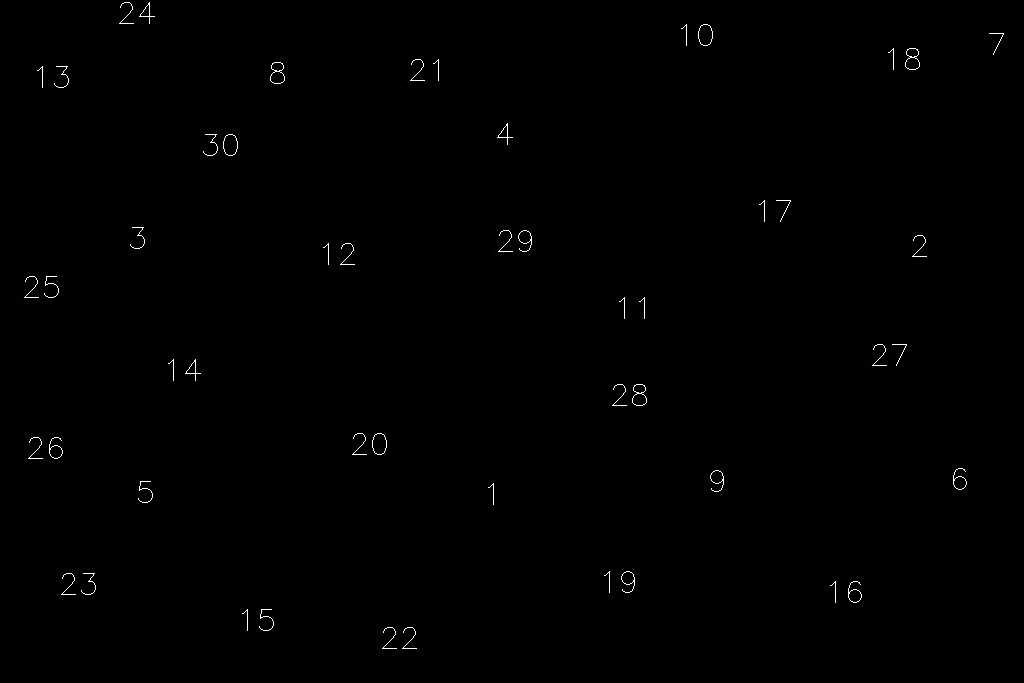

In [30]:
cv2_imshow(markers_copy)

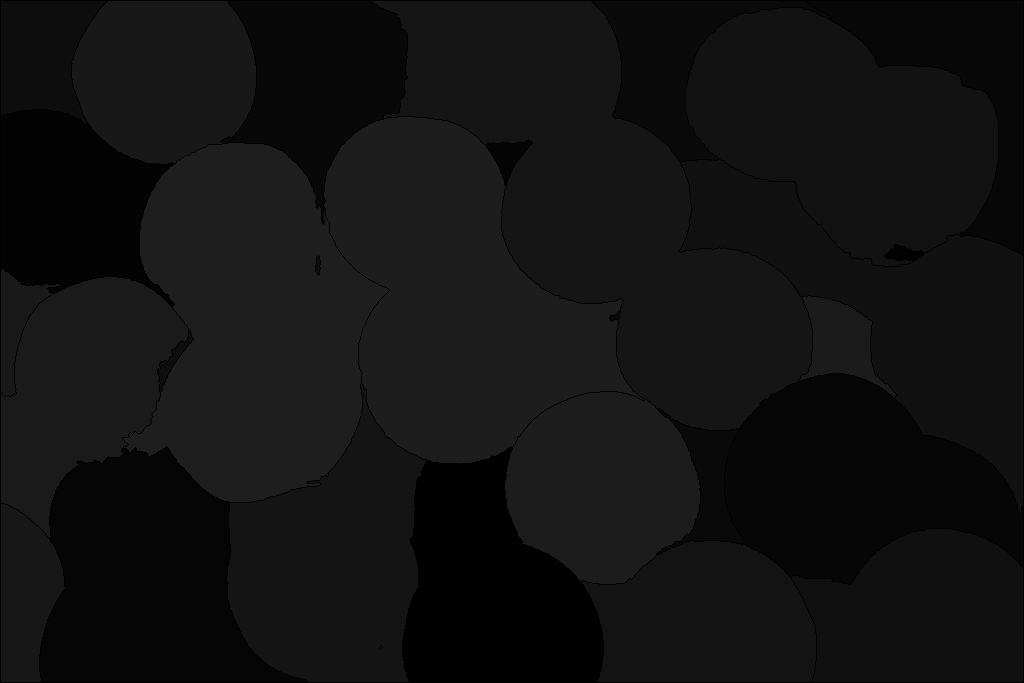

In [31]:
markers = markers.astype(np.int32)
segmented = cv2.watershed(img, markers)
cv2_imshow(segmented)

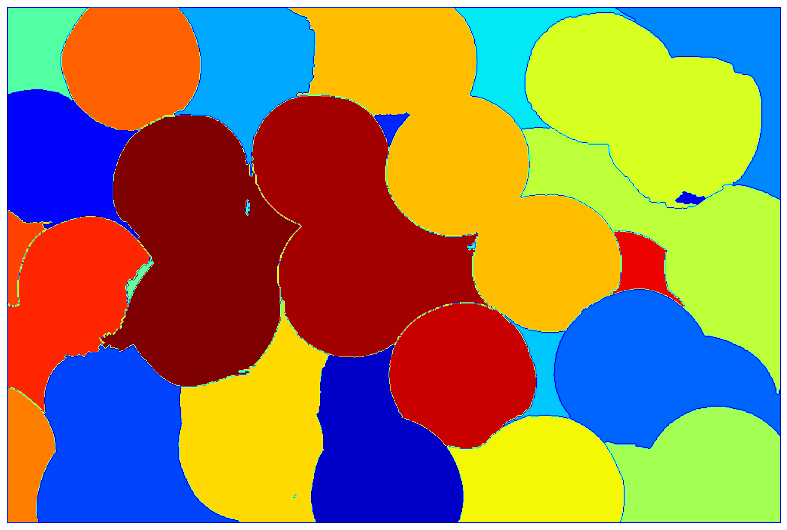

In [32]:
dpi = plt.rcParams['figure.dpi']
figsize = img.shape[1] / float(dpi), img.shape[0] / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(segmented, cmap="jet")
filename = "markers.jpg"
plt.axis('off')
plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

In [33]:
from PIL import Image

overlay = cv2.imread("markers.jpg")
overlay = np.asarray(overlay)

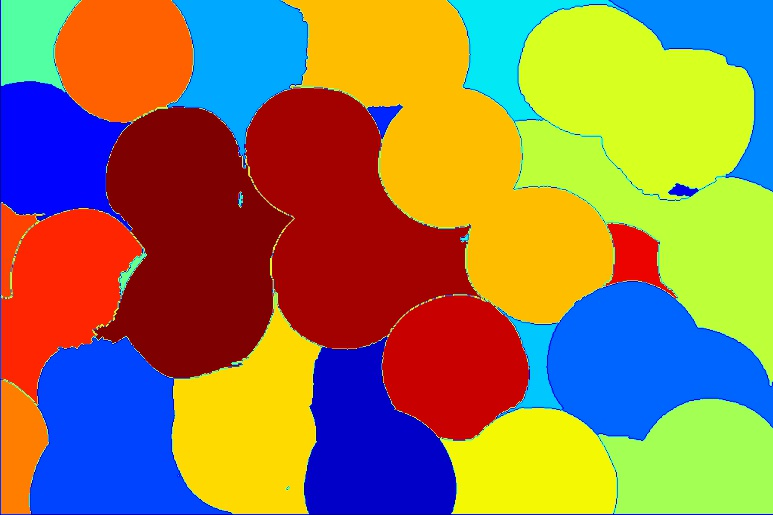

In [34]:
cv2_imshow(overlay)

In [35]:
img_copy = img.copy()
overlay_copy = overlay.copy()
final_img = img.copy()

In [36]:
overlay_copy = cv2.resize(overlay_copy, (img_copy.shape[1], img_copy.shape[0]))
final_img = cv2.addWeighted(overlay_copy, 0.5, img_copy, 0.5,	0)

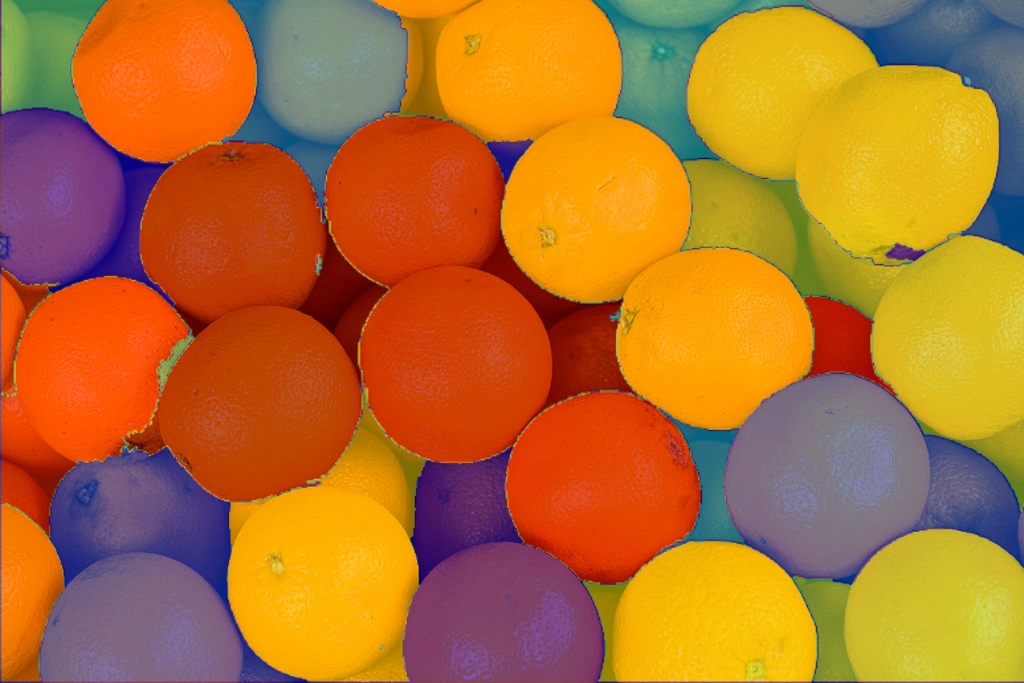

In [37]:
cv2_imshow(final_img)

In [38]:
img_c = img.copy() 
img_c[segmented == -1] = [255, 0, 0]

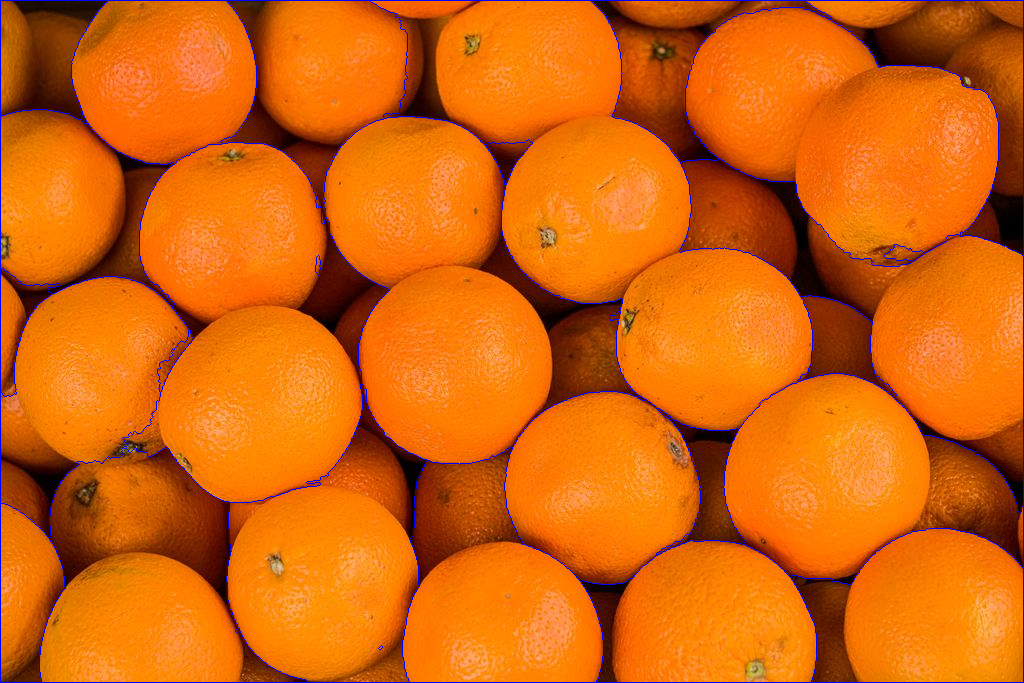

In [39]:
cv2_imshow(img_c)